In [ ]:
Entreno de un ConvNet VGG19 preentrenado con Imagenet y
entrenando conjunto de datos pequeño y FINE TUNING
Conjunto de datos de 4 clases
Utilizaremos un conjunto de datos reducido:
- Conjunto de entrenamiento: 1.000 muestras x clase 
- Conjunto de validación: 300 muestras x clase
- Conjunto de test: 300 muestras x clase
El conjunto de datos: balanced_dataset
contiene tres carpetas, train, validation y test, cada una con 4 clases

In [1]:
from  keras  import  applications
from  keras.preprocessing.image  import  ImageDataGenerator 
from keras.optimizers import SGD
from  keras.applications.vgg19 import VGG19 
from  keras.models  import  Sequential,  Model
from  keras.layers  import  Dropout,  Flatten,  Dense, Input 
top_model_weights_path  =  'VGG19_FE_model_3.h5'

img_width = 224
img_height = 224

nb_epochs = 60
batch_size  =  64  #  reduce  to  5  in  order  to  be  able  to  compute  the  calcs

train_dir  =  "balanced_dataset/train" 
validation_dir = "balanced_dataset/validation" 
test_dir  =  "balanced_dataset/test"

NB_VGG19_FREEZE_LAYERS = 4
nb_train = 4000
nb_validation = 1200
nb_test = 1200
nb_classes = 4


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_tensor = Input(shape=(img_width, img_height, 3))  #  another  way  to  shape  the  input

base_model = applications.VGG19(
    weights='imagenet',  
    include_top=False, 
    input_tensor=input_tensor)

In [3]:
# top model
top_model = Sequential() 
top_model.add(Flatten(input_shape=base_model.output_shape[1:])) 
top_model.add(Dense(256,  activation='relu')) 
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes,  activation='softmax'))

# base model has its weights, now we load the weights on the top layer 
top_model.load_weights("VGG/VGG19_FE_model_3.h5")

# we join base and top it has to be updated to api2
model_total  =  Model(input = base_model.input,  output = top_model(base_model.output))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  if sys.path[0] == '':


In [4]:
model_total.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-NB_VGG19_FREEZE_LAYERS]:
    layer.trainable = False

In [6]:
# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f1e45d5b390> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45d5b358> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45d5b4e0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1e45d5bf98> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45d78780> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45d8ee48> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1e45d30d30> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45d415f8> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45d51e80> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45d04240> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45cf49b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1e45d15630> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45cc7630> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45cc7f60> False
<keras.layers.convolutional.Conv2D object at 0x7f1e45c69fd0> Fa

In [7]:
#PREPROCESSING + DATA AUGMENTATION
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip  =  True, 
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory( 
    train_dir, 
    target_size=(img_width,img_height), 
    batch_size=batch_size, 
    class_mode='categorical')

test_datagen  =  ImageDataGenerator(rescale=1. / 255)  #  not  in  the  val  data 

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='categorical')


Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [8]:
#Compile model
model_total.compile(optimizer=SGD(lr=1e-4,  momentum=0.9), 
                    loss='categorical_crossentropy',  
                    metrics=['accuracy'])

In [9]:
#Fit model
history = model_total.fit_generator( 
    train_generator, 
    samples_per_epoch=nb_train, 
    epochs=nb_epochs,
    verbose  =  1, 
    validation_data=validation_generator, 
    validation_steps=nb_validation)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=62, verbose=1, validation_steps=1200, validation_data=<keras.pre..., epochs=60)`
  


Epoch 1/60
62/62 [==============================] - 628s 10s/step - loss: 0.8835 - acc: 0.6497 - val_loss: 0.6354 - val_acc: 0.7374
Epoch 2/60
62/62 [==============================] - 626s 10s/step - loss: 0.7005 - acc: 0.7177 - val_loss: 0.5066 - val_acc: 0.7934
Epoch 3/60
62/62 [==============================] - 624s 10s/step - loss: 0.6826 - acc: 0.7359 - val_loss: 0.4764 - val_acc: 0.8209
Epoch 4/60
62/62 [==============================] - 628s 10s/step - loss: 0.6275 - acc: 0.7510 - val_loss: 0.3997 - val_acc: 0.8351
Epoch 5/60
62/62 [==============================] - 625s 10s/step - loss: 0.5868 - acc: 0.7666 - val_loss: 0.4999 - val_acc: 0.7924
Epoch 6/60
62/62 [==============================] - 628s 10s/step - loss: 0.5735 - acc: 0.7752 - val_loss: 0.3838 - val_acc: 0.8451
Epoch 7/60
62/62 [==============================] - 624s 10s/step - loss: 0.5584 - acc: 0.7818 - val_loss: 0.3795 - val_acc: 0.8458
Epoch 8/60
62/62 [==============================] - 624s 10s/step - loss: 0.

In [10]:
model_total.save_weights('VGG/VGG19_FT_model_1.h5')

In [11]:
def print_graphics (history):
    import  matplotlib.pyplot  as  plt
    #Mostramos otro tipo de grafico
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.tittle('Trainning and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.tittle('Trainning and validation loss')
    plt.legend()

    plt.show()

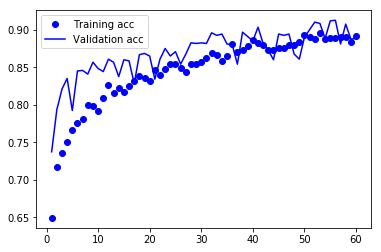

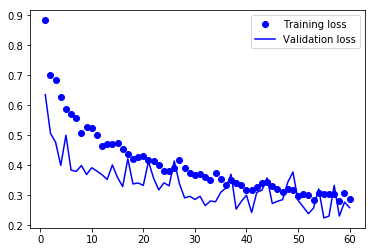

In [13]:
print_graphics (history)

In [14]:
model_total.evaluate_generator(test_generator)

[0.272254011631012, 0.899166665871938]